<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Variable_Selection/Choosing_the_best_polynomial_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3.1 The Validation Set Approach

In [1]:
# imports and setup
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

#pd.set_option('precision', 2) # number precision for pandas
#pd.set_option('display.max_rows', 12)
#pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

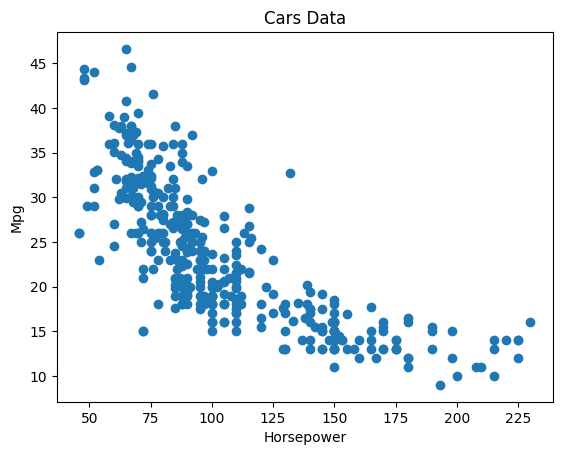

In [2]:
# load data
url = 'https://raw.githubusercontent.com/mcnica89/ISL-python/master/datasets/Auto.csv'
auto = pd.read_csv(url, na_values=['?'])
auto.dropna(axis=0, inplace=True)

auto.cylinders = auto.cylinders.astype('category')
auto.name = auto.name.astype('category')

auto.reset_index(inplace=True)

auto['horsepower_2'] = np.power(auto.horsepower, 2)
auto['horsepower_3'] = np.power(auto.horsepower, 3)
auto['horsepower_4'] = np.power(auto.horsepower, 4)
auto['horsepower_5'] = np.power(auto.horsepower, 5)

# Polynomial Features using sklearn:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
polf = pol.fit_transform(auto.loc[:, 'horsepower'].values.reshape(-1, 1))

plt.xlabel("Horsepower")
plt.ylabel("Mpg")
plt.title("Cars Data")
plt.plot(auto['horsepower'],auto['mpg'],'o')

# "Ordinary" Validation

Lets try and decide what polynomial power to use using ordinary validation

In [3]:
from sklearn.model_selection import train_test_split

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3', 'horsepower_4', 'horsepower_5']], auto.mpg

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

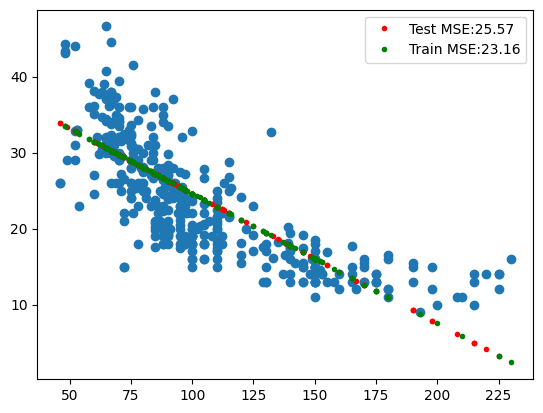

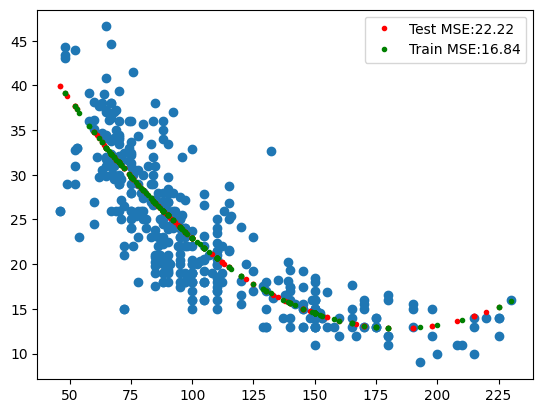

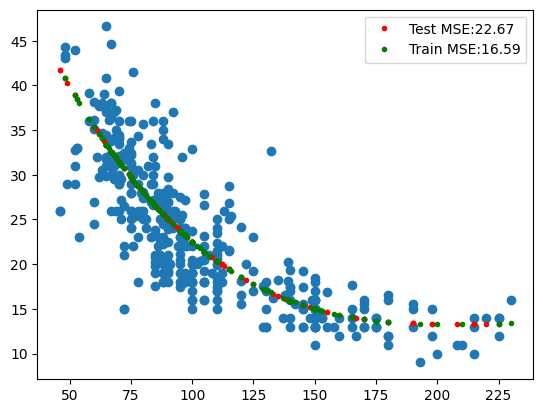

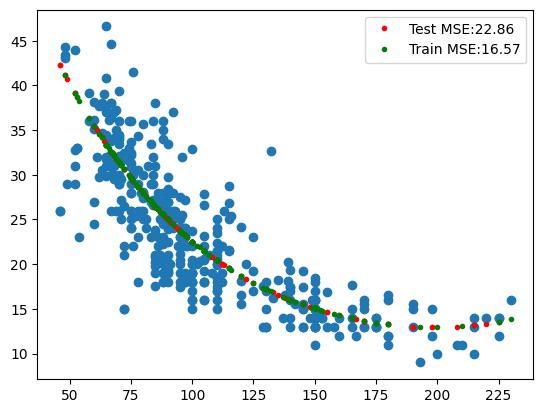

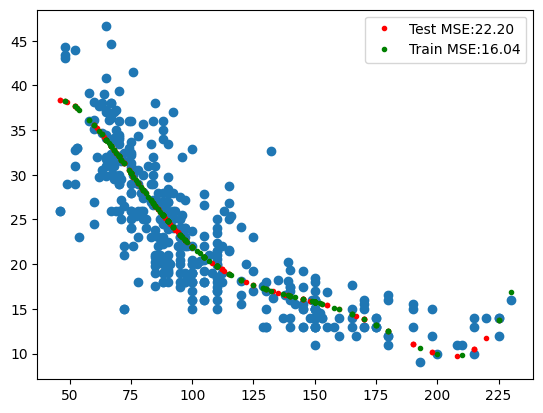

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def try_models(X_train,X_test,y_train,y_test, num_models = 5, plot_them=True):


  # ols model with intercept
  lm = [LinearRegression(fit_intercept=True) for i in range(num_models)]

  def slice_data(df):
    ans = [
      df.loc[:, ['horsepower']].values.reshape(-1, 1),
      df.loc[:, ['horsepower', 'horsepower_2']],
      df.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3']],
      df.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3','horsepower_4']],
      df.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3','horsepower_4','horsepower_5']]
    ]
    return ans

  train_data = slice_data(X_train)
  test_data = slice_data(X_test)


  lm_fit = [lm[i].fit(train_data[i], y_train) for i in range(num_models)]

  lm_train_predict = [lm_fit[i].predict(train_data[i]) for i in range(num_models)]

  lm_test_predict = [lm_fit[i].predict(test_data[i]) for i in range(num_models)]

  train_mses = [mean_squared_error(y_train, lm_train_predict[i]) for i in range(num_models)]
  test_mses = [mean_squared_error(y_test, lm_test_predict[i]) for i in range(num_models)]

  if plot_them == True:
    for i in range(num_models):

      plt.plot(auto['horsepower'],auto['mpg'],'o')
      plt.plot(X_test['horsepower'],lm_test_predict[i],'.r',label=f'Test MSE:{test_mses[i]:.2f}')
      plt.plot(X_train['horsepower'],lm_train_predict[i],'.g',label=f'Train MSE:{train_mses[i]:.2f}')

      plt.legend()
      plt.show()

  return train_mses,test_mses

_,_ = try_models(X_train, X_test, y_train, y_test)

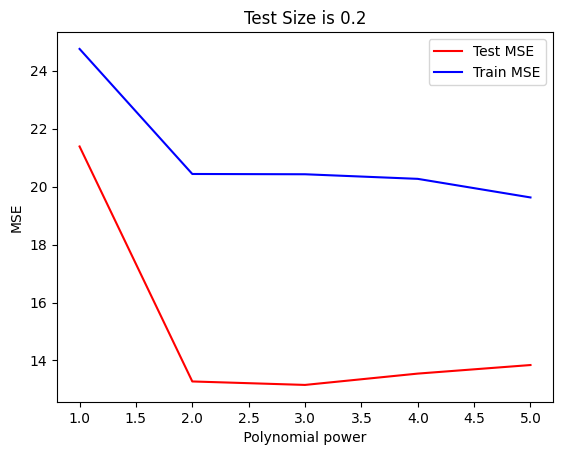

In [5]:
num_models = 5
num_retries = 1
my_test_size = 0.2

for j in range(num_retries):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size)

  train_mses, test_mses = try_models(X_train, X_test, y_train, y_test, num_models,False)

  if j==0:
    my_label_test = "Test MSE"
    my_label_train = "Train MSE"
  else:
    my_label_test = ""
    my_label_train = ""

  plt.plot( [1+i for i in range(num_models)], test_mses, 'r', label=my_label_test)
  plt.plot( [1+i for i in range(num_models)], train_mses, 'b', label=my_label_train)
  plt.xlabel( " Polynomial power ")
  plt.ylabel( "MSE")

plt.title(f"Test Size is {my_test_size}")
plt.legend()

#plt.show()

# 5.3.2 Leave-One-Out Cross-Validation

In [6]:
from sklearn.model_selection import LeaveOneOut

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3', 'horsepower_4', 'horsepower_5']], auto.mpg

loocv = LeaveOneOut()
loocv.get_n_splits(X)

392

In [7]:
loocv_mse = []
lm = LinearRegression(fit_intercept=True)

for train_index, test_index in loocv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lm1_fit = lm.fit(X_train.loc[:, 'horsepower'].values.reshape(-1, 1), y_train)
    lm1_predict = lm1_fit.predict(X_test.loc[:, 'horsepower'].values.reshape(-1, 1))

    loocv_mse.append(mean_squared_error(y_test, lm1_predict))

np.array(loocv_mse).mean()

24.231513517929226

In [8]:
# using sklearn cross_validation_score
from sklearn.model_selection import cross_val_score

lm = LinearRegression(fit_intercept=True)

cval = cross_val_score(lm,
                       auto.loc[:, 'horsepower'].values.reshape(-1, 1),
                       auto.mpg,
                       cv=len(auto), # k=n k-Fold -> LOOCV
                       n_jobs=-1,
                       scoring='neg_mean_squared_error')
-cval.mean()

24.231513517929226

In [9]:
# Loop for 5 degree polinomial linear regressions with LOOCV

loocv_poly = {}

for i in range(1, 6):

    loocv_mse = []

    for train_index, test_index in loocv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if i == 1:
            X_TRAIN = X_train.iloc[:,0:1].values.reshape(-1, 1)
            X_TEST = X_test.iloc[:,0:1].values.reshape(-1, 1)
        else:
            X_TRAIN = X_train.iloc[:,0:i]
            X_TEST = X_test.iloc[:,0:i]

        loocv_mse.append(
            mean_squared_error(
                y_test,
                LinearRegression(fit_intercept=True)
                .fit(
                    X_TRAIN,
                    y_train
                )
                .predict(
                    X_TEST
                )
            )
        )

        loocv_poly['lm' + str(i) + '_MSE'] = np.array(loocv_mse).mean()

In [10]:
loocv_poly

{'lm1_MSE': 24.231513517929226,
 'lm2_MSE': 19.24821312448967,
 'lm3_MSE': 19.33498406402931,
 'lm4_MSE': 19.424430310232463,
 'lm5_MSE': 19.033212486158245}

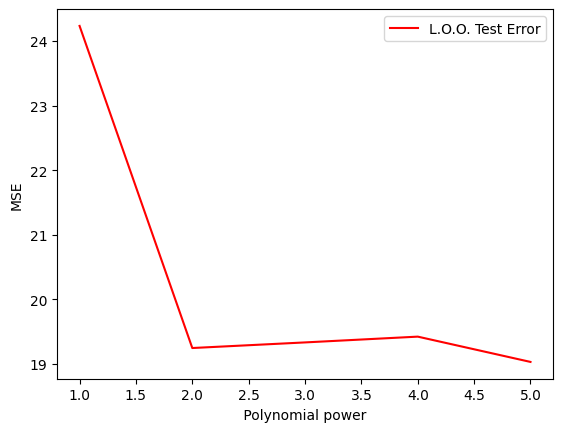

In [11]:
plt.plot( [1+i for i in range(num_models)], list(loocv_poly.values()), 'r', label="L.O.O. Test Error")
plt.xlabel( " Polynomial power ")
plt.ylabel( "MSE")
plt.legend()

# 5.3.3 k-Fold Cross-Validation

In [12]:
from sklearn.model_selection import KFold

X, y = auto.loc[:, ['horsepower', 'horsepower_2', 'horsepower_3', 'horsepower_4', 'horsepower_5']], auto.mpg

kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
# Loop for 5 degree polinomial linear regressions with k-Fold CV

kf_poly = {}

for i in range(1, 6):

    kf_mse = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if i == 1:
            X_TRAIN = X_train.iloc[:,0:1].values.reshape(-1, 1)
            X_TEST = X_test.iloc[:,0:1].values.reshape(-1, 1)
        else:
            X_TRAIN = X_train.iloc[:,0:i]
            X_TEST = X_test.iloc[:,0:i]

        kf_mse.append(
            mean_squared_error(
                y_test,
                LinearRegression(fit_intercept=True)
                .fit(
                    X_TRAIN,
                    y_train
                )
                .predict(
                    X_TEST
                )
            )
        )

        kf_poly['lm' + str(i) + '_MSE'] = np.array(kf_mse).mean()

kf_poly

{'lm1_MSE': 24.199808197692477,
 'lm2_MSE': 19.228636614268016,
 'lm3_MSE': 19.26626534663179,
 'lm4_MSE': 19.351092272836148,
 'lm5_MSE': 19.023233396518712}

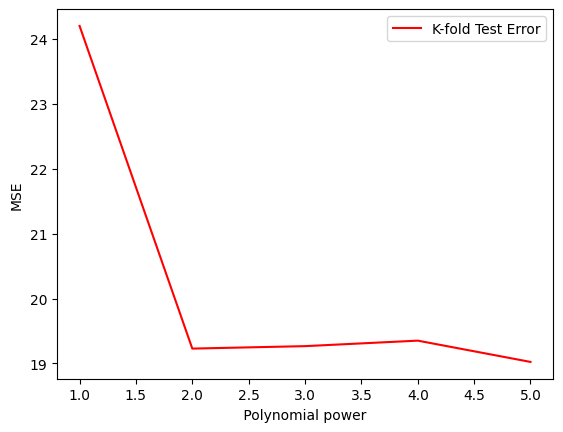

In [14]:
plt.plot( [1+i for i in range(num_models)], list(kf_poly.values()), 'r', label="K-fold Test Error")
plt.xlabel( " Polynomial power ")
plt.ylabel( "MSE")
plt.legend()